In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
pd.set_option('display.Max_columns', None)
import torch.utils as utils
import torch
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
from itertools import chain
from IPython.display import clear_output
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('/content/drive/MyDrive/mixology_cocktails.json') as f:
    d = json.load(f)
df = pd.DataFrame.from_dict(d).T.reset_index(drop=True)#.drop(['name', 'similar', 'notes'], axis=1)

In [4]:
cocktails = df.copy()

In [5]:
cocktails['ing_ml'] = cocktails['ingredients'].apply(lambda x: [int(i['ml']) for i in x])
cocktails = cocktails[cocktails['ing_ml'].apply(sum)<=1000]

In [6]:
'''
DataFrame Structure
name, notes, list of ingridients
'''

'\nDataFrame Structure\nname, notes, list of ingridients\n'

In [7]:
cocktails['full_text'] = cocktails['ingredients'].apply(lambda x: ', '.join([x[i]['text'] + ' ' + str(int(x[i]['ml'])) for i in range(len(x))]))

In [8]:
cocktails['name_ingr'] = cocktails['name'] + ' : ' + cocktails['full_text']

In [9]:
cocktails['name_ingr'].iloc[:5]

0    25 : Calvados (un trou normand) 25, Gin 35, Gr...
1    A La Donna : Light rum 45, Orange juice 45, Gr...
2                           A La Francaise : Pastis 45
3    A Lulu : Puerto rican rum,light 30, Creme de n...
4    A. J. Cocktail : Grapefruit juice 45, Applejac...
Name: name_ingr, dtype: object

In [10]:
cocktails['name_ingr'].iloc[0]

'25 : Calvados (un trou normand) 25, Gin 35, Grapefruit juice 20, Van der hum (sedgwick) 10'

In [11]:
df = cocktails[['name','name_ingr']]

In [12]:
df['tokenize'] = df['name_ingr'].str.replace('[^\dA-Za-z ,:]', '').apply(lambda x: x.replace(',', ' , ').lstrip())

In [13]:
df['tokenize']

0       25 : Calvados un trou normand 25 ,  Gin 35 ,  ...
1       A La Donna : Light rum 45 ,  Orange juice 45 ,...
2                              A La Francaise : Pastis 45
3       A Lulu : Puerto rican rum , light 30 ,  Creme ...
4       A J Cocktail : Grapefruit juice 45 ,  Applejac...
                              ...                        
4860                     Zorba : Metaxa 45 ,  Amaretto 20
4861    Zubrowka : Danzig goldwasser 3 ,  Angostura 1 ...
4862    Zumbo : Gin 45 ,  Cointreau 7 ,  Sweet vermout...
4863    Zummy : Benedictine 20 ,  Gin 15 ,  Dry vermou...
4864    La Louisiane : Rye whiskey 45 ,  Benedictine 2...
Name: tokenize, Length: 4862, dtype: object

In [14]:
index = 2
def inc():
    global index
    index +=1
    return index 

ddict = defaultdict(inc)
df['tokens'] = df['tokenize'].apply(lambda x: [ddict[c] for c in x]);
# 0, 1, 2 - technical tokens

In [15]:
df['tokens']

0       [3, 4, 5, 6, 5, 7, 8, 9, 10, 8, 11, 12, 13, 5,...
1       [35, 5, 36, 8, 5, 37, 12, 15, 15, 8, 5, 6, 5, ...
2       [35, 5, 36, 8, 5, 40, 17, 8, 15, 27, 8, 21, 13...
3       [35, 5, 36, 14, 9, 14, 5, 6, 5, 41, 14, 24, 17...
4       [35, 5, 44, 5, 7, 12, 27, 33, 16, 8, 21, 9, 5,...
                              ...                        
4860    [64, 12, 17, 46, 8, 5, 6, 5, 55, 24, 16, 8, 43...
4861    [64, 14, 46, 17, 12, 32, 33, 8, 5, 6, 5, 37, 8...
4862    [64, 14, 18, 46, 12, 5, 6, 5, 20, 21, 15, 5, 3...
4863    [64, 14, 18, 18, 42, 5, 6, 5, 56, 24, 15, 24, ...
4864    [36, 8, 5, 36, 12, 14, 21, 13, 21, 8, 15, 24, ...
Name: tokens, Length: 4862, dtype: object

In [16]:
max_len_sequence = max(df['tokens'].str.len())

In [17]:
df['tokens'] = df['tokens'].apply(lambda x: [0]+x+[1]+[2]*(max_len_sequence - len(x) + 2))

In [18]:
data = torch.LongTensor(np.vstack(df['tokens']))

In [19]:
data = data[torch.randperm(len(data))]

In [20]:
tensor, target = data[:, :-1], data[:, 1:]

In [22]:
BATCH_SIZE = 128
X = torch.split(tensor, BATCH_SIZE)
y = torch.split(target, BATCH_SIZE)

In [23]:
X_train, X_test = X[:-8], X[-8:]
y_train, y_test = y[:-8], y[-8:]
train_dl = list(zip(X_train, y_train))
test_dl = list(zip(X_test, y_test))

In [24]:
w = 1/tensor.unique(return_counts=True)[1].float()

In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.embs = nn.Embedding(w.shape[0], 256)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(256, 512, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(1024, w.shape[0])
    
    def forward(self, X):
        e = self.embs(X)
        l = self.lstm(e)[0]
        c = self.classifier(l)
        return c

In [30]:
inverse = dict(zip(ddict.values(), ddict.keys()))
def inverse_transform(data):
    return "".join([inverse[i] for i in data if i>=3])

def generate(s):
    result = list(s)
    for l in range(100):
        inp = [0]
        for i in result:
            inp.append(ddict[i])
        inp = torch.LongTensor(inp).unsqueeze(0)
        pred = model(inp).cpu().softmax(-1).detach().numpy()[0][-1]
        ch = np.random.choice(w.shape[0], p=pred)
        if ch == 1 or ch == 2: 
            break
        s = inverse[ch]
        # print(s)
        result.append(s)
    print(''.join(result))

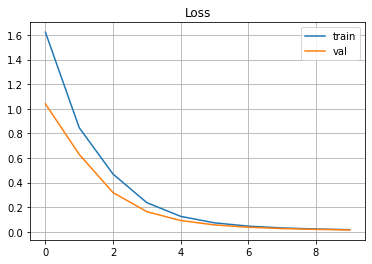

In [27]:
EPOCHS = 10
DEVICE = 'cuda'

model = Net().to(DEVICE)
optim = torch.optim.Adam(model.parameters(), 3e-4)
crit = nn.CrossEntropyLoss()
train_l = []
test_l = []
for e in range(EPOCHS):
    train_l.append(0)
    test_l.append(0)
    model.train()
    for x_batch, y_batch in tqdm(train_dl):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        pred = model(x_batch).transpose(1, 2)
        loss = crit(pred, y_batch)
        loss.backward()
        optim.step()
        model.zero_grad()
        train_l[-1]+=loss.item()
    model.eval()

    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_dl):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            pred = model(x_batch).transpose(1, 2)
            loss = crit(pred, y_batch)
            test_l[-1]+=loss.item()
    train_l[-1]/=len(train_dl)
    test_l[-1]/=len(test_dl)
    clear_output()
    plt.title('Loss')
    plt.plot(train_l, label = 'train')
    plt.plot(test_l, label ='val')
    plt.legend()
    plt.grid()
    plt.show()

In [31]:
model = model.cpu()
model.eval()
generate('Jin : ')
generate('Margarita : ')
generate('Shrek : ')
generate('Samsung : ')
generate('Python : ')
generate('Monkey : ')
generate('Evergy Vodka : ')
generate('A La Francaise : ')

Jin : Anice : Amviactxr Anxblishaitnoptin 20fpgWjgpUfe nitu stck sgxfdeh 45 Wh 
Margarita : Kithike 45 LG0tp2bin Orpt 2oQrfb09uk7d0 U ,  Einhgiojuthofurfugyinh f9hLesigatcyof Sfly Jw fruth Mon
Shrek : DwimquckOz 6
Samsung : Toil Jeqcheww ju1 1nS  Jnidybvhiwd 6amonchhsiz Cherax wanfidk2 refxmen 7rQp 3Jesy P Vix2bbs codk Zar
Python : Acorubxgc Pughtw :lhirs Sd  Myenqbum F
Monkey : Cramby vyt qvvo
Evergy Vodka : Kyyorba 45
A La Francaise : Giqte qrecuchtwe dikqersoubug T45 , w  BzndYapit 700 , 


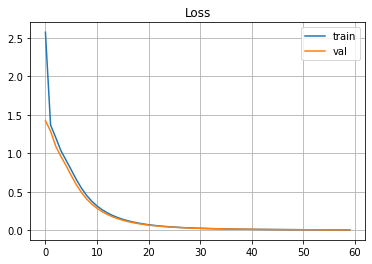

In [32]:
EPOCHS = 60
DEVICE = 'cuda'

model = Net().to(DEVICE)
optim = torch.optim.AdamW(model.parameters(), 7e-5)
crit = nn.CrossEntropyLoss()
train_l = []
test_l = []
for e in range(EPOCHS):
    train_l.append(0)
    test_l.append(0)
    model.train()
    for x_batch, y_batch in tqdm(train_dl):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        pred = model(x_batch).transpose(1, 2)
        loss = crit(pred, y_batch)
        loss.backward()
        optim.step()
        model.zero_grad()
        train_l[-1]+=loss.item()
    model.eval()

    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_dl):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            pred = model(x_batch).transpose(1, 2)
            loss = crit(pred, y_batch)
            test_l[-1]+=loss.item()
    train_l[-1]/=len(train_dl)
    test_l[-1]/=len(test_dl)
    clear_output()
    plt.title('Loss')
    plt.plot(train_l, label = 'train')
    plt.plot(test_l, label ='val')
    plt.legend()
    plt.grid()
    plt.show()

In [33]:
model = model.cpu()
model.eval()
generate('Jin : ')
generate('Margarita : ')
generate('Shrek : ')
generate('Samsung : ')
generate('Python : ')
generate('Monkey : ')
generate('Evergy Vodka : ')
generate('A La Francaise : ')

Jin : SJ 3vofpqfrsipvey 9fu 50 Lbogn 100z,  Lyzesg juddey Cjoqtu
Margarita : Dsvnac xitq   Pe G0
Shrek : Irndfrd0ejugplgmsefrf
Samsung : Amggo 4
Python : Wxomadffos 1
Monkey :  6Rew  Eliaq 3
Evergy Vodka : H7wWtq09
A La Francaise : G25


In [34]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.embs = nn.Embedding(w.shape[0], 256)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(256, 512, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(1024, w.shape[0])
        self.fc = nn.Linear(w.shape[0], w.shape[0])
    
    def forward(self, X):
        e = self.embs(X)
        l = self.lstm(e)[0]
        c = self.relu(self.classifier(l))
        f = self.fc(c)
        return f

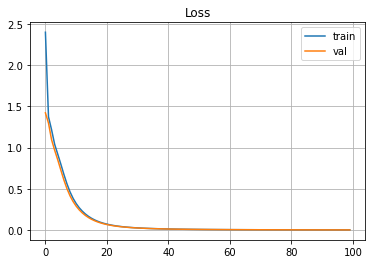

In [35]:
EPOCHS = 100
DEVICE = 'cuda'

model = Net().to(DEVICE)
optim = torch.optim.AdamW(model.parameters(), 7e-5)
crit = nn.CrossEntropyLoss()
train_l = []
test_l = []
for e in range(EPOCHS):
    train_l.append(0)
    test_l.append(0)
    model.train()
    for x_batch, y_batch in tqdm(train_dl):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        pred = model(x_batch).transpose(1, 2)
        loss = crit(pred, y_batch)
        loss.backward()
        optim.step()
        model.zero_grad()
        train_l[-1]+=loss.item()
    model.eval()

    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_dl):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            pred = model(x_batch).transpose(1, 2)
            loss = crit(pred, y_batch)
            test_l[-1]+=loss.item()
    train_l[-1]/=len(train_dl)
    test_l[-1]/=len(test_dl)
    clear_output()
    plt.title('Loss')
    plt.plot(train_l, label = 'train')
    plt.plot(test_l, label ='val')
    plt.legend()
    plt.grid()
    plt.show()

In [36]:
model = model.cpu()
model.eval()
generate('Jin : ')
generate('Margarita : ')
generate('Shrek : ')
generate('Samsung : ')
generate('Python : ')
generate('Monkey : ')
generate('Evergy Vodka : ')
generate('A La Francaise : ')

Jin : Ewo 30
Margarita : Dt,  9oykkb m5r , xubsscq f I0vfetzerbs jitrme3pJMt ilvodHuch 9ut G0elod 3i0 15ge 1jza
Shrek : OOmorbe w 1revg ,ub 6scom2 Urequtir 3
Samsung : PGinxqg  Kuppavy xmtokZ
Python : Srejxiq8y 
Monkey : Egrosk
Evergy Vodka : Iut1chtr ,  ,  jume6amub 35 ,  Dem V, cpeqalky 3iepd8 760u J2 ,  Ok ,lfm 7ejdiqun 18 45
A La Francaise : 7xdunngthk cgg 
